# 5 Implied volatility

### Using Heston model to simulate real market conditions (stock paths and option prices)
### Then using BS model to calculate implied volatility and perform delta hedging

### compare with file 5_delta_hedge_bs.ipynb and 5_delta_hedge_heston.ipynb

In [25]:
# Initialize system paths and import necessary modules
import sys
import os
import pandas as pd

# Set up working directory and module paths
current_path = os.getcwd()
print("Current Path:", current_path)
current_path = current_path.replace('/samples', '')
print(sys.path)
sys.path.append(current_path)
print(sys.path)


Current Path: /Users/yang/PycharmProjects/Option/samples
['/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/Users/yang/PycharmProjects/Option']
['/Users/yang/PycharmProjects/Option/samples', '/Users/yang/PycharmProjects/Option', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/pydev', '/Applications/PyCharm.app/Contents/plugins/python-ce/helpers/jupyter_debug', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/U

In [26]:
# Import numerical and financial libraries
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
import time

# Import custom utility classes
from src.utils import plot_fig
from src.QlCalendar import QlCalendar
from src.QlStocks import QlStocks
from src.QlEuropeanOptions import QlEuropeanOptions


In [27]:
# Set model parameters for delta hedging simulation
r = 0.05  # Risk-free interest rate
S0 = 100  # Initial stock price
strike = 100  # Option strike price

# Black-Scholes parameters
sigma = 0.13  # Underlying stock volatility

# Heston model parameters
V0 = 0.04  # Initial volatility
kappa = 2.0  # Mean reversion speed
theta = 0.04  # Long-term volatility mean
sigma_heston = 0.3  # Volatility of volatility
rho = -0.7  # Price-volatility correlation

# Time parameters
T = 1  # Time to maturity (years)
optionType = "option_heston"
steps = 252  # Number of time steps (trading days)
paths = 1000


In [28]:
# Initialize QuantLib calendar and calculate maturity date
start_date = ql.Date(3, 1, 2023)
ql_calendar = QlCalendar(
    init_date=start_date,
    init_risk_free_rate=r,
)

end_date = ql_calendar.cal_date_advance(times=steps, time_unit='days')


In [29]:
# Verify date calculations
print("Maturity Date:", end_date)
print("Days between start and end:", ql_calendar.calendar.businessDaysBetween(start_date, end_date))


Maturity Date: January 10th, 2024
Days between start and end: 252


In [30]:
# Initialize Heston model and corresponding financial instruments
ql_stocks = QlStocks(ql_calendar)
ql_stocks.add_heston(codes='STCKHM',
                     stock_prices=S0,
                     v0=V0,
                     kappa=kappa,
                     theta=theta,
                     rho=rho,
                     sigma=sigma_heston,
                     dividend_rates=0.0,
                     )

# Create stock and option objects
stock_heston = ql_stocks.stock('STCKHM')
option_heston = stock_heston.set_european_option(
    option_type='call',
    strike_price=strike,
    maturity_date=end_date
)
option_heston.analytic_engine()
print(option_heston.NPV(), option_heston.delta_numerical())


10.51753271945904 0.693021748899092


# Generate simulated stock price paths using Heston model

使用步数: 252 步
timesteps: 252, Time length(per year): 1.0191780821917809start_date: January 3rd, 2023 end_date: January 10th, 2024


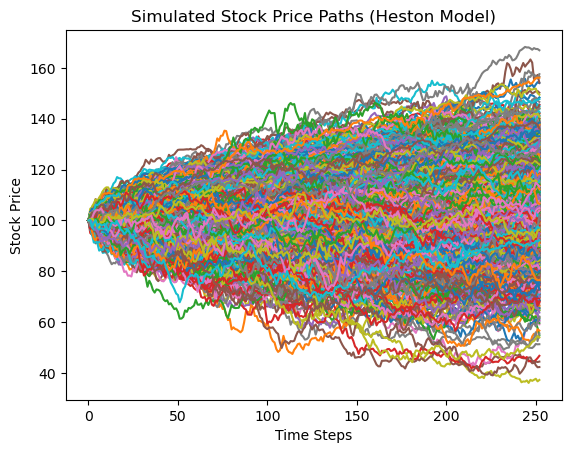

In [31]:
# Generate and plot 1000 simulated stock price paths
stock_prices = stock_heston.stock_paths(paths, steps).T
plt.plot(stock_prices)
plt.title('Simulated Stock Price Paths (Heston Model)')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


In [32]:
# Display statistics for final stock prices
print(stock_prices[-1].max(), stock_prices[-1].min(),
      stock_prices[-1].mean(), stock_prices[-1].std())

166.92871728734437 37.31014964405064 105.4944778064728 19.70423963525123


# Calculate corresponding option prices using Heston model

In [33]:
# Calculate option NPV and delta for all paths and time steps
ql_calendar.set_today(start_date)
dt = 1 / steps

call_prices = np.zeros((steps, paths))
delta_heston = np.zeros((steps, paths))

t0 = time.time()
for i in np.arange(0, steps):
    call_prices[i] = option_heston.NPV_multi(stock_prices[i])
    delta_heston[i] = option_heston.delta_numerical_multi(stock_prices[i])
    ql_calendar.to_next_trading_date()

print('Option pricing calculation time: ', time.time() - t0)

Option pricing calculation time:  59.43851709365845


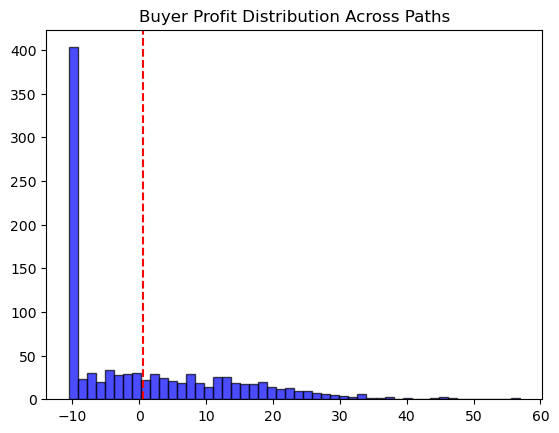

In [34]:
#
buyer_profits = np.zeros(paths)
for i in range(paths):
        buyer_profits[i] = max(call_prices[-1, i] - call_prices[0, i], -call_prices[0, i])
avg_buyer_profit = np.mean(buyer_profits)
std_buyer_profit = np.std(buyer_profits)
plt.hist(buyer_profits, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.axvline(x=avg_buyer_profit, color='red', linestyle='--',
            label=f'Mean: {avg_buyer_profit:.2f}\nStd: {std_buyer_profit:.2f}')
plt.title('Buyer Profit Distribution Across Paths', fontsize=12)
plt.show()

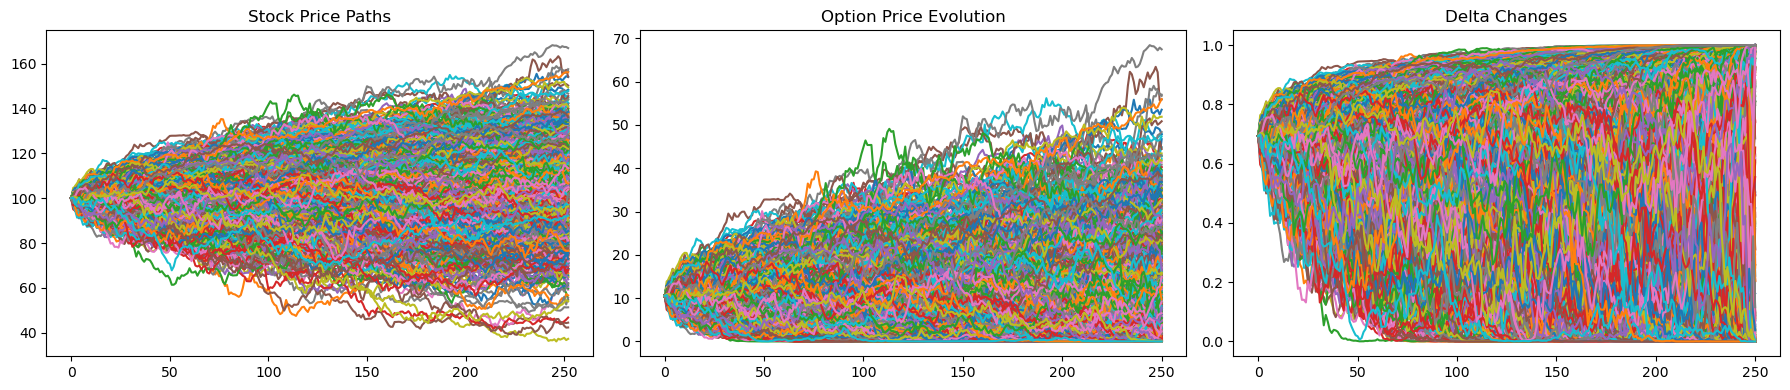

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].plot(stock_prices)
ax[0].set_title('Stock Price Paths')

ax[1].plot(call_prices[:-1])
ax[1].set_title('Option Price Evolution')

ax[2].plot(delta_heston[:-1])
ax[2].set_title('Delta Changes')

plt.tight_layout()
plt.show()

# Black-Scholes Model Implementation
## Using BS model with implied volatility for hedging (assuming unknown price model)

In [36]:
# Initialize Black-Scholes model with same price quotes as Heston
ql_calendar.set_today(start_date)
price_quotes = stock_heston.get_price_quote()
price_quotes.setValue(S0)
ql_stocks.add_black_scholes('STCKBS', price_quotes, volatility=sigma)
stock_bs = ql_stocks.stock('STCKBS')
option_bs = stock_bs.set_european_option(
    option_type='call',
    strike_price=strike,
    maturity_date=end_date
)
option_bs.analytic_engine()

In [37]:
# Initialize arrays for delta hedging tracking
dt = 1 / steps

option_qty = 1
implied_vol = np.zeros((steps, paths))
call_delta = np.zeros((steps, paths))
stock_qty = np.zeros((steps, paths))
option_account = option_qty * call_prices
stock_account = np.zeros((steps, paths))
cash_account = np.zeros((steps, paths))


In [38]:
# Set initial hedge positions (t=0)
today_prices = stock_prices[0]
today_vol, today_delta = option_bs.impliedVolatility_and_delta_multi(
    NPVs=call_prices[0],
    stock_prices=today_prices)

implied_vol[0] = today_vol
call_delta[0] = today_delta
stock_qty[0] = today_delta
stock_account[0] = - today_delta * today_prices
cash_account[0] = - (stock_account[0] + option_account[0])


In [39]:
# Execute delta hedging strategy across all paths
ql_calendar.set_today(start_date)
# ql_calendar.set_today(ql.Date(8,1,2024))
t0 = time.time()
for i in np.arange(1, steps):
    print(ql_calendar.today())
    today_prices = stock_prices[i]
    if ql_calendar.today() == ql.Date(8,1,2024):
        print()
    # Calculate delta using implied volatility that matches Heston NPV
    heston_delta = delta_heston[i]
    today_vol, today_delta = option_bs.impliedVolatility_and_delta_multi(
        NPVs = call_prices[i],
        pre_vol= today_vol,
        stock_prices = today_prices)

    # Update hedge positions
    implied_vol[i] = today_vol
    call_delta[i] = today_delta
    stock_qty[i] = - today_delta
    stock_account[i] = - today_delta * today_prices

    # Update cash account with rebalancing costs and interest
    cash_account[i] = cash_account[i - 1] * (np.exp(r * dt)) - (-today_delta + call_delta[i - 1]) * today_prices

    # Move to next trading day
    ql_calendar.to_next_trading_date()

# Calculate final portfolio PnL
pnl = option_account + stock_account + cash_account

print(f"Delta hedging completed in {time.time() - t0:.2f} seconds")


January 3rd, 2023
January 4th, 2023
January 5th, 2023
January 6th, 2023
January 9th, 2023
January 10th, 2023
January 11th, 2023
January 12th, 2023
January 13th, 2023
January 16th, 2023
January 17th, 2023
January 18th, 2023
January 19th, 2023
January 20th, 2023
January 26th, 2023
January 27th, 2023
January 30th, 2023
January 31st, 2023
February 1st, 2023
February 2nd, 2023
February 3rd, 2023
February 6th, 2023
February 7th, 2023
February 8th, 2023
February 9th, 2023
February 10th, 2023
February 13th, 2023
February 14th, 2023
February 15th, 2023
February 16th, 2023
February 17th, 2023
February 20th, 2023
February 21st, 2023
February 22nd, 2023
February 23rd, 2023
February 24th, 2023
February 27th, 2023
February 28th, 2023
March 1st, 2023
March 2nd, 2023
March 3rd, 2023
March 6th, 2023
March 7th, 2023
March 8th, 2023
March 9th, 2023
March 10th, 2023
March 13th, 2023
March 14th, 2023
March 15th, 2023
March 16th, 2023
March 17th, 2023
March 20th, 2023
March 21st, 2023
March 22nd, 2023
March

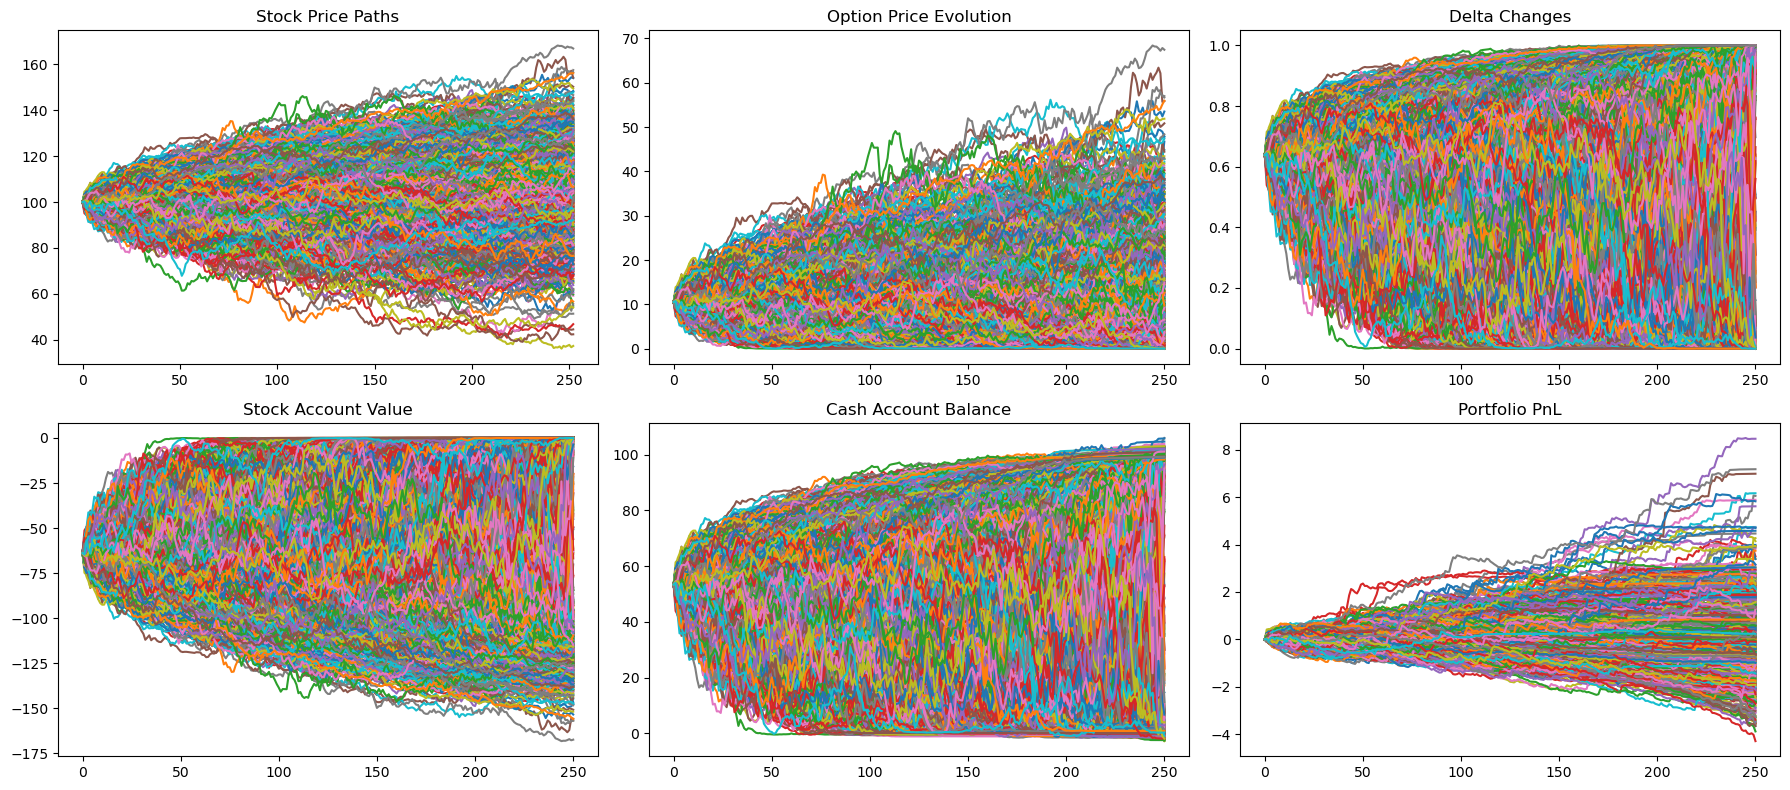

In [40]:
# Visualize hedging results across all components
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

ax[0, 0].plot(stock_prices)
ax[0, 0].set_title('Stock Price Paths')

ax[0, 1].plot(call_prices[:-1])
ax[0, 1].set_title('Option Price Evolution')

ax[0, 2].plot(call_delta[:-1])
ax[0, 2].set_title('Delta Changes')

ax[1, 0].plot(stock_account[:-1])
ax[1, 0].set_title('Stock Account Value')

ax[1, 1].plot(cash_account[:-1])
ax[1, 1].set_title('Cash Account Balance')

ax[1, 2].plot(pnl[:-1])
ax[1, 2].set_title('Portfolio PnL')

plt.tight_layout()
plt.show()


In [41]:
# Calculate average PnL across all paths
print(f"Average PnL: {pnl.mean():.2f}")


Average PnL: -0.01


## Delta Hedging Simulation Analysis
#
#### Profit Distribution Visualization
#### Buyer vs Seller Profit Calculation

In [42]:
# Calculate buyer and seller profits for all paths
# Buyer profit is simply the option account value at maturity (option_account[-1])
# Seller profit depends on whether the option is exercised (stock price > strike)
buyer_profits = np.zeros(paths)
seller_profits = np.zeros(paths)

for i in range(paths):
    # Buyer's profit: max(option_account[-1,i] - option_account[0,i], -option_account[0,i])
    buyer_profits[i] = max(option_account[-1, i] - option_account[0, i], -option_account[0, i])

    # Seller's profit calculation depends on exercise scenario
    if stock_prices[-1, i] > strike:
        # If exercised: cash_account + strike received
        seller_profits[i] = -cash_account[-1, i] + strike
    else:
        # If not exercised: stock_account + cash_account
        seller_profits[i] = -stock_account[-1, i] - cash_account[-1, i]

total_profit = buyer_profits - seller_profits

# Calculate statistics for display
avg_buyer_profit = np.mean(buyer_profits)
avg_seller_profit = np.mean(seller_profits)
std_buyer_profit = np.std(buyer_profits)
std_seller_profit = np.std(seller_profits)
avg_total_profit = np.mean(total_profit)
std_total_profit = np.std(total_profit)


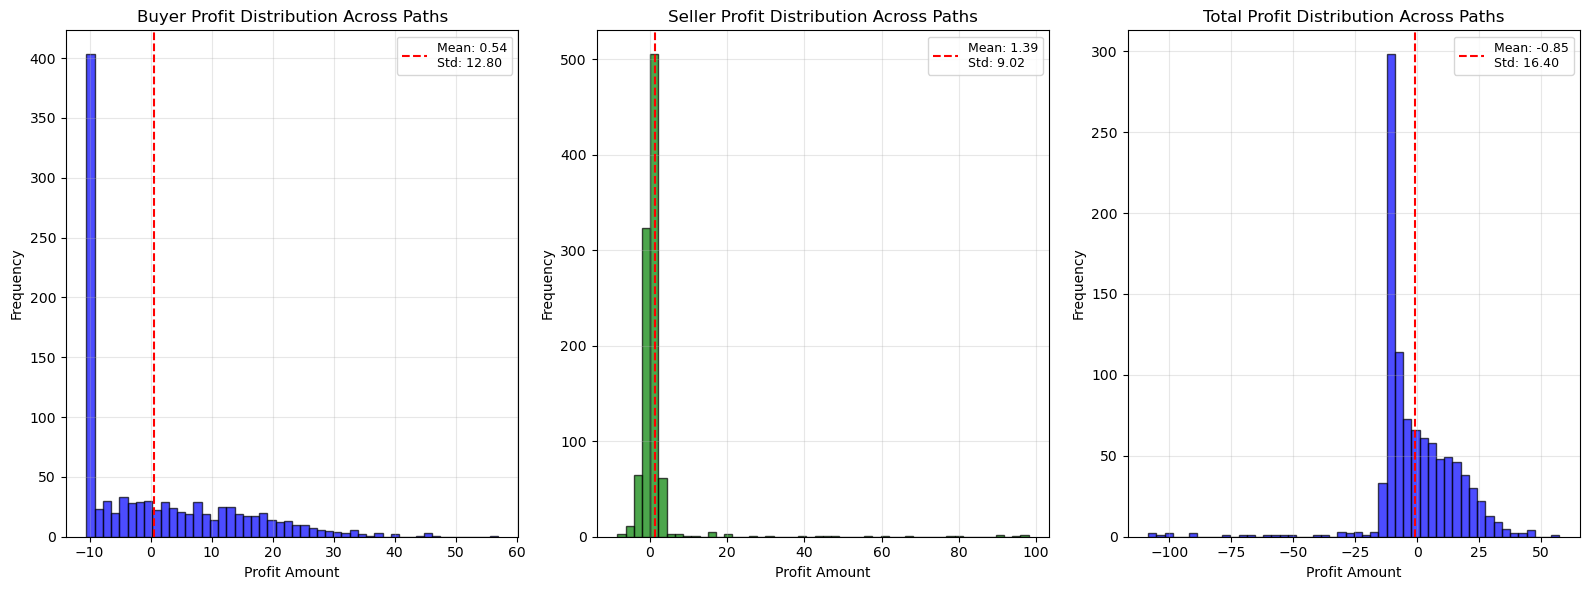

In [43]:
# Create figure with two subplots for buyer and seller profits
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

# Buyer profits histogram
ax1.hist(buyer_profits, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax1.axvline(x=avg_buyer_profit, color='red', linestyle='--',
            label=f'Mean: {avg_buyer_profit:.2f}\nStd: {std_buyer_profit:.2f}')
ax1.set_title('Buyer Profit Distribution Across Paths', fontsize=12)
ax1.set_xlabel('Profit Amount', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Seller profits histogram
ax2.hist(seller_profits, bins=50, color='green', alpha=0.7, edgecolor='black')
ax2.axvline(x=avg_seller_profit, color='red', linestyle='--',
            label=f'Mean: {avg_seller_profit:.2f}\nStd: {std_seller_profit:.2f}')
ax2.set_title('Seller Profit Distribution Across Paths', fontsize=12)
ax2.set_xlabel('Profit Amount', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Total profits histogram
ax3.hist(total_profit, bins=50, color='blue', alpha=0.7, edgecolor='black')
ax3.axvline(x=avg_total_profit, color='red', linestyle='--',
            label=f'Mean: {avg_total_profit:.2f}\nStd: {std_total_profit:.2f}')
ax3.set_title('Total Profit Distribution Across Paths', fontsize=12)
ax3.set_xlabel('Profit Amount', fontsize=10)
ax3.set_ylabel('Frequency', fontsize=10)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [44]:
# Print summary statistics
print("Buyer Profit Summary:")
print(f"  Average: {avg_buyer_profit:.2f}")
print(f"  Standard Deviation: {std_buyer_profit:.2f}")
print(f"  Minimum: {np.min(buyer_profits):.2f}")
print(f"  Maximum: {np.max(buyer_profits):.2f}")
print(f"  Median: {np.median(buyer_profits):.2f}")

print("\nSeller Profit Summary:")
print(f"  Average: {avg_seller_profit:.2f}")
print(f"  Standard Deviation: {std_seller_profit:.2f}")
print(f"  Minimum: {np.min(seller_profits):.2f}")
print(f"  Maximum: {np.max(seller_profits):.2f}")
print(f"  Median: {np.median(seller_profits):.2f}")


Buyer Profit Summary:
  Average: 0.54
  Standard Deviation: 12.80
  Minimum: -10.52
  Maximum: 56.92
  Median: -4.17

Seller Profit Summary:
  Average: 1.39
  Standard Deviation: 9.02
  Minimum: -8.47
  Maximum: 98.09
  Median: 0.34


In [45]:
implied_vol[:,i].shape

(252,)

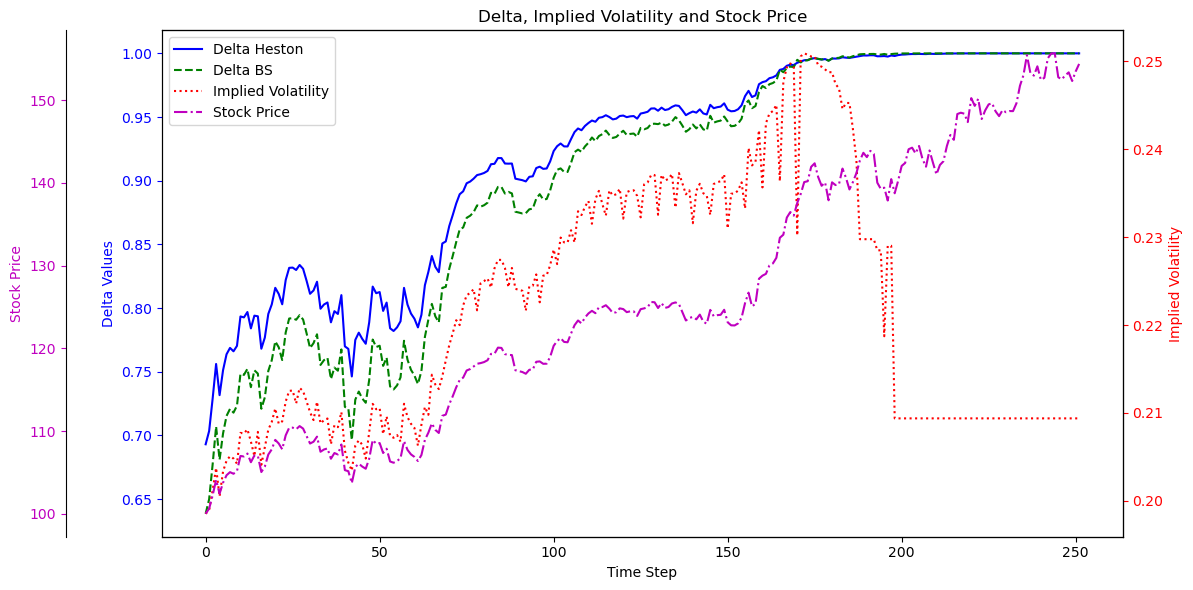

In [46]:
i = 260
x = np.arange(steps)
y1 = delta_heston[:,i]
y2 = call_delta[:,i]
y3 = implied_vol[:,i]
y4 = stock_prices[:-1,i]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis (Delta values)
ax1.plot(x, y1, 'b-', label='Delta Heston')
ax1.plot(x, y2, 'g--', label='Delta BS')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Delta Values', color='b')
ax1.tick_params(axis='y', colors='b')

# Right Y-axis (Implied Volatility)
ax2 = ax1.twinx()
ax2.plot(x, y3, 'r:', label='Implied Volatility')
ax2.set_ylabel('Implied Volatility', color='r')
ax2.tick_params(axis='y', colors='r')

# Third Y-axis (Stock Price) - positioned on the left with offset
ax3 = ax1.twinx()
ax3.spines["left"].set_position(("axes", -0.10))
ax3.plot(x, y4, 'm-.', label='Stock Price')
ax3.set_ylabel('Stock Price', color='m')
ax3.tick_params(axis='y', colors='m')
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()

# Combine legends
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Delta, Implied Volatility and Stock Price')
fig.tight_layout()
plt.show()


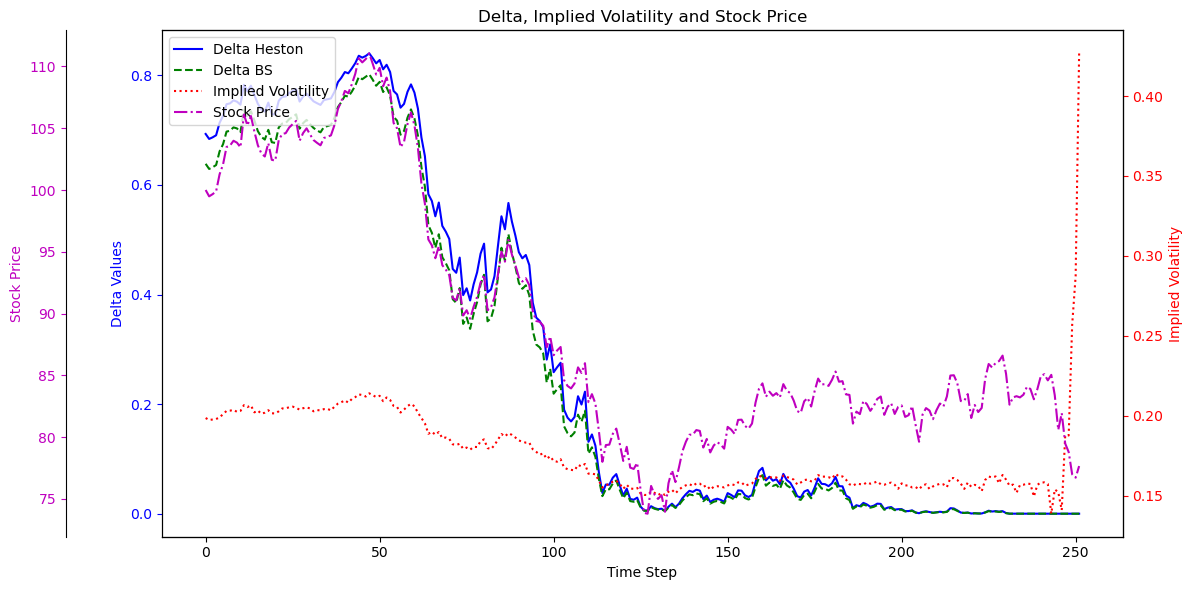

In [47]:
i = 31
x = np.arange(steps)
y1 = delta_heston[:,i]
y2 = call_delta[:,i]
y3 = implied_vol[:,i]
y4 = stock_prices[:-1,i]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis (Delta values)
ax1.plot(x, y1, 'b-', label='Delta Heston')
ax1.plot(x, y2, 'g--', label='Delta BS')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Delta Values', color='b')
ax1.tick_params(axis='y', colors='b')

# Right Y-axis (Implied Volatility)
ax2 = ax1.twinx()
ax2.plot(x, y3, 'r:', label='Implied Volatility')
ax2.set_ylabel('Implied Volatility', color='r')
ax2.tick_params(axis='y', colors='r')

# Third Y-axis (Stock Price) - positioned on the left with offset
ax3 = ax1.twinx()
ax3.spines["left"].set_position(("axes", -0.10))
ax3.plot(x, y4, 'm-.', label='Stock Price')
ax3.set_ylabel('Stock Price', color='m')
ax3.tick_params(axis='y', colors='m')
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()

# Combine legends
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Delta, Implied Volatility and Stock Price')
fig.tight_layout()
plt.show()


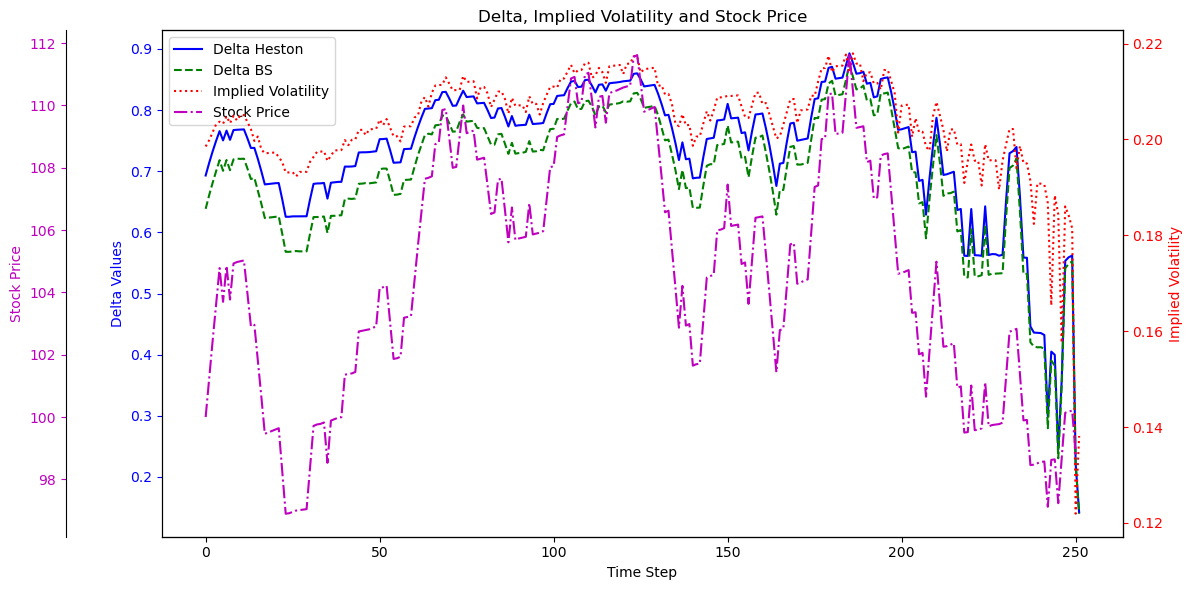

In [48]:
i = 0
x = np.arange(steps)
y1 = delta_heston[:,i]
y2 = call_delta[:,i]
y3 = implied_vol[:,i]
y4 = stock_prices[:-1,i]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left Y-axis (Delta values)
ax1.plot(x, y1, 'b-', label='Delta Heston')
ax1.plot(x, y2, 'g--', label='Delta BS')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Delta Values', color='b')
ax1.tick_params(axis='y', colors='b')

# Right Y-axis (Implied Volatility)
ax2 = ax1.twinx()
ax2.plot(x, y3, 'r:', label='Implied Volatility')
ax2.set_ylabel('Implied Volatility', color='r')
ax2.tick_params(axis='y', colors='r')

# Third Y-axis (Stock Price) - positioned on the left with offset
ax3 = ax1.twinx()
ax3.spines["left"].set_position(("axes", -0.10))
ax3.plot(x, y4, 'm-.', label='Stock Price')
ax3.set_ylabel('Stock Price', color='m')
ax3.tick_params(axis='y', colors='m')
ax3.yaxis.set_label_position("left")
ax3.yaxis.tick_left()

# Combine legends
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Delta, Implied Volatility and Stock Price')
fig.tight_layout()
plt.show()
